**Bibliotecas**

In [1]:
#Para realizar paralelismo
import swifter

#Coletados Comentários
from google_play_scraper import Sort, reviews

#Armazenamento em DF
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Transformar a coluna de versões para fazer filtro melhores
from packaging.version import parse

#Tratamentos
import re
import emoji
import nltk
from nltk.corpus import stopwords
import stanza

#Sentimentos dos Comentários
from pysentimiento import create_analyzer

#Gráficos
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

c:\Users\Computador\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Download de pacotes
nltk.download("stopwords")
stanza.download('pt')

nlp = stanza.Pipeline(lang='pt', processors='tokenize,mwt,pos,lemma')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Computador\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-06-13 09:14:02 INFO: Downloaded file to C:\Users\Computador\stanza_resources\resources.json
2025-06-13 09:14:02 INFO: Downloading default packages for language: pt (Portuguese) ...
2025-06-13 09:14:05 INFO: File exists: C:\Users\Computador\stanza_resources\pt\default.zip
2025-06-13 09:14:08 INFO: Finished downloading models and saved to C:\Users\Computador\stanza_resources
2025-06-13 09:14:08 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2025-06-13 09:14:08 INFO: Downloaded file to C:\Users\Computador\stanza_resources\resources.json
2025-06-13 09:14:09 INFO: Loading these models for language: pt (Portuguese):
| Processor | Package         |
-------------------------------
|

# Funções 
**tratamento_de_texto**: Funciona para realizar limpezas com o nome da operados para o termo "operados", porque a Claro e a Vivo podem ter algum tipo de conotação específica se interpretadas pelo modelo sentimento, transformação dos emojis para formatos textuais e qualquer coisa relacionadas a possíveis links nos comentaráios. Além da lemmatização dos comentários para um formato mais geral das palavras. 

**classificar_tema**: Após testar alguns modelos de classificação de tópicos, optei por fazer a classificação manual dos temas mais falados com uma lista de termos agrupados em grandes temas gerais que ocorrem com esse setor.

**analisar_sentimento_todos**: O Pysentimiento possui 4 funções de análise de sentimento, optei de realizar a análise sentimento e emoção. Para as emoções, que são gerados diversas emoções em inglês, optei por agrupar em 8 grandes emoções para melhorar a análise.

In [3]:
stopwords_pt = set(stopwords.words("portuguese"))

In [4]:
def tratamento_de_texto(texto):
    texto = emoji.demojize(texto, language="pt")
    texto = texto.lower()
    texto = re.sub(r'\b(vivo|claro|tim)\b', 'operadora', texto)
    texto = re.sub(r'(:[^:\s]+:)', r' \1 ', texto)
    texto = re.sub(r"http\S+|www\S+|https\S+", "", texto)
    texto = re.sub(r"[^a-zá-úà-üç\s]", "", texto)
    texto = re.sub(r'\s+', ' ', texto).strip()

    doc = nlp(texto)
    
    lemmas = [word.lemma for sent in doc.sentences for word in sent.words if word.lemma not in stopwords_pt and len(word.lemma) > 2]
    
    return " ".join(lemmas)

In [5]:
temas_manuais = {
    "Operadora": [r"operadora"],
    "App": [r"\bapp\b", r"\baplicativo\b"],
    "Login": [r"logar", r"\blogin\b", r"acessar", r"entrar", r"cadastrar", r"cadastro"],
    "Atualização": [r"atualização", r"atualizei", r"versão", r"nova versão", r"última atualização"],
    "Atendimento": [r"atendimento", r"chat", r"suporte", r"atendente", r"fale conosco", r"não responde", r"reclame"],
    "Usabilidade": [r"interface", r"usabilidade", r"navegação", r"botão", r"menu", r"layout", r"tela", r"confuso", r"difícil"],
    "Conta": [r"fatura", r"boleto", r"cobrança", r"pagamento", r"conta", r"valor indevido", r"preço errado"],
    "Plano": [r"serviço", r"plano", r"contrato", r"assinatura", r"benefício", r"pacote"],
    "Internet": [r"internet", r"sinal", r"conexão", r"velocidade", r"3g", r"4g", r"5g", r"wi[- ]?fi", r"queda"],
    "Recarga": [r"recarga", r"créditos", r"saldo"],
    "Benefícios": [r"promoção", r"desconto", r"benefício", r"cashback", r"oferta"],
    "Desempenho": [r"bug", r"erro", r"trava", r"lento", r"crash", r"problema", r"instabilidade"],
    "Notificações": [r"notificação", r"alerta", r"mensagem push", r"aviso", r"push", r"mensagem", r"sms"]
}


In [6]:
def classificar_tema(texto, temas_dict):
    texto = texto.lower()
    temas_encontrados = []
    for tema, padroes in temas_dict.items():
        for padrao in padroes:
            if re.search(padrao, texto):
                temas_encontrados.append(tema)
                break  # Evita múltiplas adições do mesmo tema
    return temas_encontrados  # Sem categoria 'Outro'

In [5]:
analyzers = {
    "sentiment": create_analyzer(task="sentiment", lang="pt"),
    "emotion": create_analyzer(task="emotion", lang="pt"),
}

# Grupos para emoções resumidas
grupos_emocoes = {
    "alegria": ["admiration", "amusement", "approval", "excitement",
                "gratitude", "joy", "love", "optimism", "pride"],
    "tristeza": ["disappointment", "remorse", "sadness"],
    "raiva": ["anger", "annoyance", "disapproval", "disgust"],
    "medo": ["fear", "nervousness", "embarrassment"],
    "surpresa": ["surprise", "realization"],
    "confianca": ["curiosity", "desire", "caring"],
    "confusao": ["confusion"],
    "neutro": ["neutral", None]
}

def analisar_sentimento_todos(texto, analyzers=analyzers):
    if not isinstance(texto, str) or not texto.strip():
        return pd.Series()

    dados = {}

    for tipo, analyzer in analyzers.items():
        resultado = analyzer.predict(texto)

        # Ajuste seguro do output
        if isinstance(resultado.output, list):
            saida = resultado.output[0] if resultado.output else None
        else:
            saida = resultado.output

        # Para emoção, substituir output pela categoria agregada
        if tipo == "emotion":
            # Pós-processamento: agregando emoções
            grupo_probs = {}
            for grupo, emocoes in grupos_emocoes.items():
                soma = sum(resultado.probas.get(e, 0) for e in emocoes)
                dados[f"{tipo}_{grupo}"] = soma
                grupo_probs[grupo] = soma
            
            # Encontrar o grupo com maior probabilidade
            if grupo_probs:
                grupo_principal = max(grupo_probs, key=grupo_probs.get)
            else:
                grupo_principal = None

            dados[f"{tipo}_output"] = grupo_principal
        else:
            # Mantém output original
            dados[f"{tipo}_output"] = saida
            # Mantém probas originais
            for k, v in resultado.probas.items():
                dados[f"{tipo}_{k}"] = v

    return pd.Series(dados)


# Extração de Comentários
Aproveitando um script feito em outro [notebook]('https://github.com/PedroReste/data_eng_insights/tree/main/web_scraping_comentarios_apps), será coletado aproximadamente 15 mil comentários de cada aplicativo na Play Store pela consistência dos dados em relação ao iOS. Além do caso brasileiro de exister, de forma majoritária, mais usuários de Android do que iOS.

In [6]:
qtd_comentarios = 5000

dados_android = []

apps = {
    "Banco do Brasil": "br.com.bb.android",
    "Bradesco": "com.bradesco",
    "Caixa": "br.com.gabba.Caixa",
    "C6": "com.c6bank.app",
    "Itau": "com.itau",
    "Inter": "br.com.intermedium",
    "Nubank": "com.nu.production",
    "Mercado Pago": "com.mercadopago.wallet",
    "Santander": "com.santander.app"
}

In [7]:
for app, app_id in apps.items():
    result, _ = reviews(
        app_id,
        lang='pt',
        country='br',
        sort=Sort.NEWEST,
        count=qtd_comentarios
    )
        
    for review in result:
        dados_android.append({
            "app": app,
            "score": review.get("score", None),
            "content": review.get("content", None),
            "app_version": review.get("appVersion", None),
            "date": review.get("at", None),
            "reply_content": review.get("replyContent", None),
            "reply_date": review.get("repliedAt", None)
        })

In [8]:
comentarios_android = pd.DataFrame(dados_android, columns=["date", "score", "app_version", "app",  "content"])
comentarios_android.to_csv("comentarios_bancos.csv", index=False)
comentarios_android.shape

(45000, 5)

# Análise de Sentimento
Nessa seção será aplicado os tratamentos necessários aos comentários extraídos da Play Store, aplicação dos modelos do Pysentimiento para entender os sentimentos e emoções do comentários e uma análise encima das informações extraidas da store e da aplicação dos modelos.

## Análises

In [9]:
comentarios_android["content_proc"] = comentarios_android["content"].swifter.apply(tratamento_de_texto)

Pandas Apply: 100%|██████████| 45000/45000 [1:19:09<00:00,  9.47it/s]


In [10]:
resultados = comentarios_android["content_proc"].swifter.apply(analisar_sentimento_todos)
df = pd.concat([comentarios_android, resultados], axis=1)

Pandas Apply: 100%|██████████| 45000/45000 [55:20<00:00, 13.55it/s]  


In [11]:
df.to_csv("comentarios_bancos_processados.csv", index=False)

In [102]:
print("Data mínima da Claro: ", df[df['app']=='Claro']['date'].min())
print("Data mínima da TIM: ", df[df['app']=='TIM']['date'].min())
print("Data mínima da Vivo: ", df[df['app']=='Vivo']['date'].min())
print("Data máxima da Claro: ", df[df['app']=='Claro']['date'].max())
print("Data máxima da TIM: ", df[df['app']=='TIM']['date'].max())
print("Data máxima da Vivo: ", df[df['app']=='Vivo']['date'].max())

Data mínima da Claro:  2024-12-11 11:32:18
Data mínima da TIM:  2024-12-12 11:37:05
Data mínima da Vivo:  2025-04-13 12:18:16
Data máxima da Claro:  2025-06-09 16:14:31
Data máxima da TIM:  2025-06-09 16:05:37
Data máxima da Vivo:  2025-06-09 16:22:06


### Sentimentos

Nesse primeiro gráfico, apenas substitui o nome original para um nome mais visível

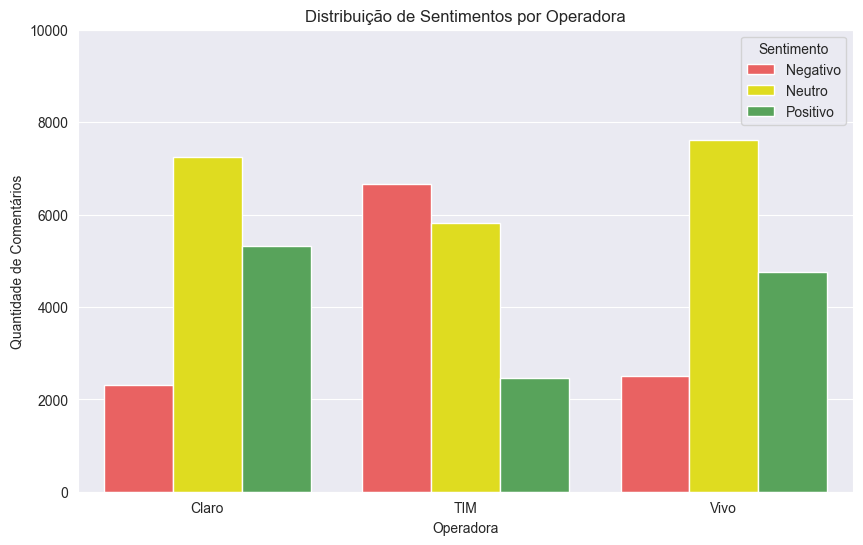

In [76]:
def map_sentiment(sent):
    if sent in ['NEG', 'negativo']:
        return 'Negativo'
    elif sent in ['NEU', 'neutro']:
        return 'Neutro'
    elif sent in ['POS', 'positivo']:
        return 'Positivo'
    else:
        return 'Outro'

df['sentimento_simplificado'] = df['sentiment_output'].apply(map_sentiment)

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

sns.countplot(
    data=df,
    x='app',
    hue='sentimento_simplificado',
    palette={'Negativo': '#FF4C4C', 'Neutro': '#FFFB00', 'Positivo': '#4CAF50'},
    hue_order=['Negativo', 'Neutro', 'Positivo']
)

plt.title("Distribuição de Sentimentos por Operadora", loc="center")
plt.xlabel("Operadora")
plt.ylabel("Quantidade de Comentários")
plt.ylim(0, 10000)
plt.legend(title="Sentimento")

plt.show()


Também investiguei os comentários comentados como **Neutros**, pela sua alta quantidade, encontrei diversos comentários compostos de de frases curtas ou de uma ou duas palavras que foram classificados como neutros, mas poderiam ser possitivos ou negativos. \

Nesse caso, além do tratamento do nome, realizei um teste para manter apenas como neutros apenas os comentários que tinha a probabilidade acima 70% de serem neutros. Os comentários que eram netruos e abaixo de 70%, foram reclassificados com o segundo sentimento mais provável, positivo ou negativo.
Após essa reclassificação, houve um crescimento maior de sentimentos positivos para a Claro e a Vivo, enquanto cresceu mais os sentimento negativos para a TIM.


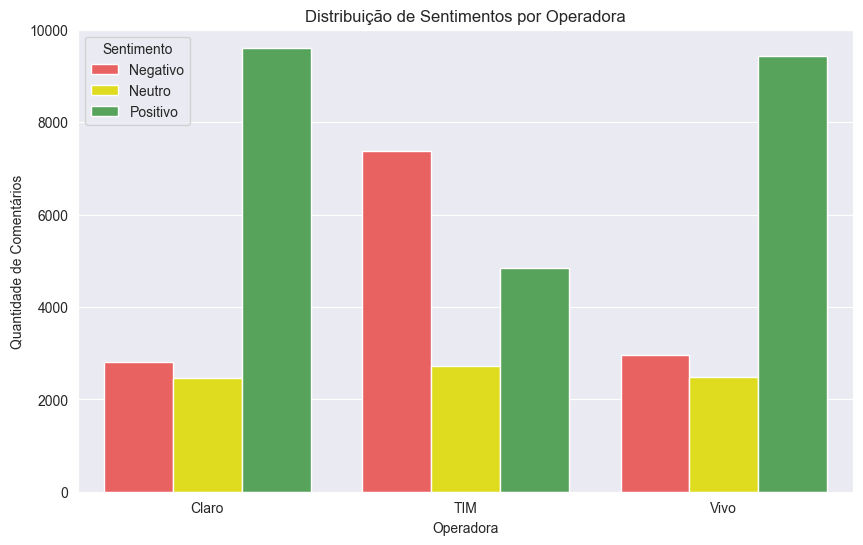

In [77]:
def map_sentiment(row, limiar_neu=0.7):
    sentiment = row.get('sentiment_output', '')
    if sentiment == 'NEG':
        return 'Negativo'
    elif sentiment == 'POS':
        return 'Positivo'
    elif sentiment == 'NEU':
        prob_pos = row.get('sentiment_POS', 0)
        prob_neu = row.get('sentiment_NEU', 0)
        prob_neg = row.get('sentiment_NEG', 0)
        if prob_neu >= limiar_neu:
            return "Neutro"
        return "Positivo" if prob_pos > prob_neg else "Negativo"
    else:
        return sentiment

df['sentimento_simplificado'] = df.apply(map_sentiment, axis=1)

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

sns.countplot(
    data=df,
    x='app',
    hue='sentimento_simplificado',
    palette={'Negativo': '#FF4C4C', 'Neutro': '#FFFB00', 'Positivo': '#4CAF50'},
    hue_order=['Negativo', 'Neutro', 'Positivo']
)

plt.title("Distribuição de Sentimentos por Operadora", loc="center")
plt.xlabel("Operadora")
plt.ylabel("Quantidade de Comentários")
plt.ylim(0, 10000)
plt.legend(title="Sentimento")

plt.show()

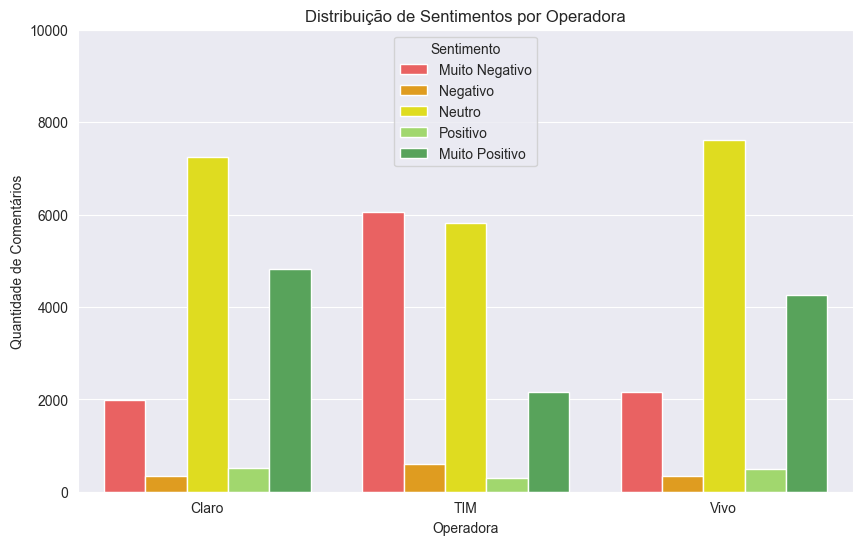

In [8]:
def map_sentiment(row):
    sentiment = row['sentiment_output']
    if sentiment == "NEG":
        prob = row.get('sentiment_NEG', 0)
        if prob < 0.7:
            return "Negativo"
        else:
            return "Muito Negativo"
    elif sentiment == "POS":
        prob = row.get('sentiment_POS', 0)
        if prob < 0.7:
            return "Positivo"
        else:
            return "Muito Positivo"
    elif sentiment == "NEU":
        return "Neutro"
    else:
        return sentiment
df['sentimento_complexo'] = df.apply(map_sentiment, axis=1)

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

sns.countplot(
    data=df,
    x='app',
    hue='sentimento_complexo',
    palette={'Muito Negativo': '#FF4C4C', 'Negativo': '#FFA500', 'Neutro': "#FFFB00",
             'Positivo': "#A0E95C", 'Muito Positivo': '#4CAF50'},
    hue_order=['Muito Negativo', 'Negativo', 'Neutro', 'Positivo', 'Muito Positivo']
)

plt.title("Distribuição de Sentimentos por Operadora", loc="center")
plt.xlabel("Operadora")
plt.ylabel("Quantidade de Comentários")
plt.ylim(0, 10000)
plt.legend(title="Sentimento")

plt.show()

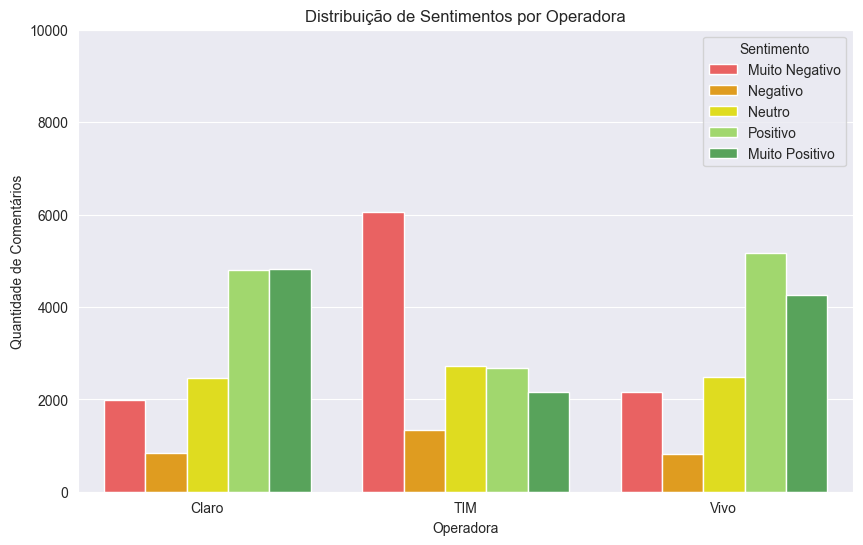

In [6]:
def map_sentiment(row):
    sentiment = row['sentiment_output']
    if sentiment == "NEG":
        prob = row.get('sentiment_NEG', 0)
        if prob < 0.7:
            return "Negativo"
        else:
            return "Muito Negativo"
    elif sentiment == "POS":
        prob = row.get('sentiment_POS', 0)
        if prob < 0.7:
            return "Positivo"
        else:
            return "Muito Positivo"
    elif sentiment == "NEU":
        prob_pos = row.get('sentiment_POS', 0)
        prob_neu = row.get('sentiment_NEU', 0)
        prob_neg = row.get('sentiment_NEG', 0)
        if prob_neu >= 0.7:
            return "Neutro"
        return "Positivo" if prob_pos > prob_neg else "Negativo"
    else:
        return sentiment
df['sentimento_complexo'] = df.apply(map_sentiment, axis=1)

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

sns.countplot(
    data=df,
    x='app',
    hue='sentimento_complexo',
    palette={'Muito Negativo': '#FF4C4C', 'Negativo': '#FFA500', 'Neutro': "#FFFB00",
             'Positivo': "#A0E95C", 'Muito Positivo': '#4CAF50'},
    hue_order=['Muito Negativo', 'Negativo', 'Neutro', 'Positivo', 'Muito Positivo']
)

plt.title("Distribuição de Sentimentos por Operadora", loc="center")
plt.xlabel("Operadora")
plt.ylabel("Quantidade de Comentários")
plt.ylim(0, 10000)
plt.legend(title="Sentimento")

plt.show()

In [45]:
values_claro = df[df['app'] == 'Claro'][['emotion_alegria', 'emotion_tristeza', 'emotion_raiva',
              'emotion_medo', 'emotion_surpresa', 'emotion_confianca',
              'emotion_confusao', 'emotion_neutro']].mean().tolist()

values_tim = df[df['app'] == 'TIM'][['emotion_alegria', 'emotion_tristeza', 'emotion_raiva',
              'emotion_medo', 'emotion_surpresa', 'emotion_confianca',
              'emotion_confusao', 'emotion_neutro']].mean().tolist()

values_vivo = df[df['app'] == 'Vivo'][['emotion_alegria', 'emotion_tristeza', 'emotion_raiva',
              'emotion_medo', 'emotion_surpresa', 'emotion_confianca',
              'emotion_confusao', 'emotion_neutro']].mean().tolist()

categories = ['Alegria', 'Tristeza', 'Raiva', 'Medo', 'Surpresa', 'Confiança', 'Confusão', 'Neutro']

# Valores de exemplo para cada operadora
values_vivo = values_vivo
values_tim = values_tim
values_claro = values_claro

# Criar subplots
fig = make_subplots(
    rows=1, cols=3,
    specs=[[{'type': 'polar'}, {'type': 'polar'}, {'type': 'polar'}]]
)

# Gráfico Vivo
fig.add_trace(go.Scatterpolar(
    r=values_vivo,  # Não fechando a linha
    theta=categories,
    fill='toself',
    name='Vivo',
    line=dict(color='royalblue'),
    opacity=0.7
), row=1, col=1)

# Gráfico TIM
fig.add_trace(go.Scatterpolar(
    r=values_tim,
    theta=categories,
    fill='toself',
    name='TIM',
    line=dict(color='firebrick'),
    opacity=0.7
), row=1, col=2)

# Gráfico Claro
fig.add_trace(go.Scatterpolar(
    r=values_claro,
    theta=categories,
    fill='toself',
    name='Claro',
    line=dict(color='darkgreen'),
    opacity=0.7
), row=1, col=3)

# Ajustar o layout geral
fig.update_layout(
    showlegend=False,
    title_text="Distribuição de Emoções por Operadora",
    height=650, width=1800,
)

fig.update_layout(
    polar=dict(radialaxis=dict(visible=False)),
    polar2=dict(radialaxis=dict(visible=False)),
    polar3=dict(radialaxis=dict(visible=False))
)


# Ajuste do posicionamento dos títulos: mais para cima
fig.add_annotation(dict(font=dict(size=16),
                        x=0.13,
                        y=1.1,
                        showarrow=False,
                        text="Vivo",
                        xref="paper",
                        yref="paper"))

fig.add_annotation(dict(font=dict(size=16),
                        x=0.5,
                        y=1.1,
                        showarrow=False,
                        text="TIM",
                        xref="paper",
                        yref="paper"))

fig.add_annotation(dict(font=dict(size=16),
                        x=0.87,
                        y=1.1,
                        showarrow=False,
                        text="Claro",
                        xref="paper",
                        yref="paper"))

fig.show()


# Classificação de Temas

passar todo o tratamento no NLTK ou outras libs para fazer uma word cloud e saber os principais temas aboradas nos comentários


**Insights**
- O período dos comentários dos apps é próximo, estando entre 10/dez/2024 e 09/jun/2025, com 15 mil comentários cada. Exceto a Vivo, que o perído é entre 13/abr/2025 e 09/jun/2025.

- Notas
    - Observando o geral das notas dos comentários do período, para todos os apps, se destaca a quantidade de avaliações máximas.
    - Exceto a TIM, que também tem muitas avaliações máximas, as avaliações de 1, são maiores.
    - Observando as notas dos comentários ao decorrer dos meses, o comportamento do geral se mantém para os meses também.
    - Não fez tanto sentido tentar verificar a nota média por versão do app que usuários tinham quando comentaram.
- Sentimentos por Versão
    - Os apps lançam muitas versão intermediárias, que dificutam uma análise mais aprofundada a partir dos comentários. Nesse caso, não foi tão relevante assim.
- Sentimentos 
    - Em um primeiro momento, encontrei diversos comentários compostos de de frases curtas ou de uma ou duas palavras que foram classificados como neutros, mas poderiam ser possitivos ou negativos.
    - Estabelecendo um limite probabildiade, comentários neutros acima 70% de serem neutros se matiam e abaixos, eram reclassificados como positivos ou negativos.
    - Com a reclassificação geral, houve um crescimento maior de sentimentos positivos para a Claro e a Vivo, enquanto cresceu mais os sentimento negativos para a TIM.
    - Detalhando os sentimentos negativos e positivos entre muito ou moderado, utilizando a mesma regra de 70% de probabilidade. A Vivo e Claro, possuem um comportamento muito semelhante.
    - No caso de TIM, se mantem distoante, com comentários muito negativos na maioria.
    - Nas emoções gerais, Vivo e Claro seguem um comportamento parecido, tendo como principal emoção a **alegria**, em seguida da **neutralidade**. Enquanto as demais emoções não possuem um expressividade alta.
    - A TIM distoa, tendo como principal emoção a **netrualidade**, seguido de **alegria** e **raiva**, refletindo o sentimento geral dos comentários.

In [10]:
df.dropna(subset="content_proc", inplace=True)

# Aplica a função de classificação de temas manuais
df['tema_manual'] = df['content_proc'].swifter.apply(lambda x: classificar_tema(x, temas_manuais))

# Explode os temas para analisar por linha
df_explodido = df.explode('tema_manual').dropna(subset=['tema_manual'])

# Calcula o sentimento contínuo ponderado
df_explodido['sentimento_continuo'] = (
    df_explodido['sentiment_POS'] * 1 +
    df_explodido['sentiment_NEU'] * 0 +
    df_explodido['sentiment_NEG'] * -1
)

Pandas Apply: 100%|██████████| 44671/44671 [00:17<00:00, 2506.57it/s] 


In [73]:
df_claro = df_explodido[df_explodido["app"] == "Claro"]

#Agrupamento por tema
df_tema = df_claro.groupby('tema_manual').agg(
    volume=('tema_manual', 'count'),
    sentimento_medio=('sentimento_continuo', 'mean')
).reset_index()

# Normaliza o volume para tamanho dos pontos no gráfico
df_tema['tamanho'] = df_tema['volume'] * 20

fig = px.scatter(
    df_tema,
    x="volume",
    y="sentimento_medio",
    size="tamanho",
    color="sentimento_medio",
    text="tema_manual",
    color_continuous_scale= ["#F74A4A", '#FFFB00', '#4CAF50'],
    range_y=[-1, 1],
    range_x=[-200, 2500],
    title="<b>Temas + Falados</b>"
)

# Ajustes visuais
fig.update_traces(textposition='top center')
fig.update_layout(
    width=700,
    height=700,
    xaxis_title="Qtd Comentários",
    yaxis_title="Sentimento",
    coloraxis_colorbar=dict(title="Sentimento"),
    coloraxis=dict(cmin=-1, cmax=1),
    template="seaborn",
    title={'font':{
            'size': 24,
            'family': 'Arial'},
        'x': 0.5,
        'xanchor': 'center',
        'y': 0.9,
    }
)

fig.show()

In [72]:
df_tim = df_explodido[df_explodido["app"] == "TIM"]

#Agrupamento por tema
df_tema = df_tim.groupby('tema_manual').agg(
    volume=('tema_manual', 'count'),
    sentimento_medio=('sentimento_continuo', 'mean')
).reset_index()

# Normaliza o volume para tamanho dos pontos no gráfico
df_tema['tamanho'] = df_tema['volume'] * 20  # Ajuste conforme necessário

fig = px.scatter(
    df_tema,
    x="volume",
    y="sentimento_medio",
    size="tamanho",
    color="sentimento_medio",
    text="tema_manual",
    color_continuous_scale= ["#F74A4A", '#FFFB00', '#4CAF50'],
    range_y=[-1, 1],
    range_x=[-200, 2500],
    title="<b>Temas + Falados</b>"
)

# Ajustes visuais
fig.update_traces(textposition='top center')
fig.update_layout(
    width=700,
    height=700,
    xaxis_title="Qtd Comentários",
    yaxis_title="Sentimento",
    coloraxis_colorbar=dict(title="Sentimento"),
    coloraxis=dict(cmin=-1, cmax=1),
    template="seaborn",
    title={'font':{
            'size': 24,
            'family': 'Arial'},
        'x': 0.5,
        'xanchor': 'center',
        'y': 0.9,
    }
)

fig.show()

In [71]:
df_vivo = df_explodido[df_explodido["app"] == "Vivo"]

#Agrupamento por tema
df_tema = df_vivo.groupby('tema_manual').agg(
    volume=('tema_manual', 'count'),
    sentimento_medio=('sentimento_continuo', 'mean')
).reset_index()

# Normaliza o volume para tamanho dos pontos no gráfico
df_tema['tamanho'] = df_tema['volume'] * 20  # Ajuste conforme necessário

fig = px.scatter(
    df_tema,
    x="volume",
    y="sentimento_medio",
    size="tamanho",
    color="sentimento_medio",
    text="tema_manual",
    color_continuous_scale= ["#F74A4A", '#FFFB00', '#4CAF50'],
    range_y=[-1, 1],
    range_x=[-200, 2500],
    title="<b>Temas + Falados</b>"
)

# Ajustes visuais
fig.update_traces(textposition='top center')
fig.update_layout(
    width=700,
    height=700,
    xaxis_title="Qtd Comentários",
    yaxis_title="Sentimento",
    coloraxis_colorbar=dict(title="Sentimento"),
    coloraxis=dict(cmin=-1, cmax=1),
    template="seaborn",
    title={'font':{
            'size': 24,
            'family': 'Arial'},
        'x': 0.5,
        'xanchor': 'center',
        'y': 0.9,
    }
)

fig.show()

# Próximas Etapas a serem feitas

### Tratamentos
- **OK** - Extração 10k comentários
- **OK** - Apenas comentários de Android
- **OK** - Data mínima e máxima dos comentários de cada app, estão coesas
- **OK** - Ortográfia
- **OK** - Emoji
- **NOTOK** - Abreviações e gírias - Muito complicado para fazer

### Análise Exploratória
- **OK** - Data mínima e máxima dos comentários de cada app, estão coesas
- **OK** - Sentimento Geral por versão
- **OK** - Volume geral por versão do app
- **OK** - Nota média dos comentários por versão
- **NOTOK** - Ironia, classificou tudo como ironia
- **OK** - Os sentimentos como neutros tem a classificação entre 0,3 e 1,0. Não teria como classficar em positivos ou negativos
- **OK** - Separação de positivos e negativos fortes e fracos
- **WIP** - Periodicidade dos comentários para realizar uma análise ao decorrer do tempo de sentimento

### Análise Exploratória
- **WIP** - classificar os temas gerais
- **WIP** - classificar os temas de neutros
- **WIP** - scatterplot vendo o volume de temas
- **WIP** - mapa de wordcloud